<a href="https://colab.research.google.com/github/drahulnayak/Enhanced-EEG-Signal-Classification-using-Deep-Learning-Features-/blob/main/_1_Final_Project_submission_of_Rahul_on_EEG_signal_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deap gdown
#DEAP is a Genetic algorithm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.5 MB/s eta 0:00:00


In [ ]:
!gdown 1ppMGBDeBD0hJbd3XhtrMuUGT-9WSfGjd

Downloading...
From (original): https://drive.google.com/uc?id=1ppMGBDeBD0hJbd3XhtrMuUGT-9WSfGjd
From (redirected): https://drive.google.com/uc?id=1ppMGBDeBD0hJbd3XhtrMuUGT-9WSfGjd&confirm=t&uuid=51e74ad4-d9e9-4b53-9cc3-99082af26ebf
To: /content/MAT_Files.zip
100% 146M/146M [00:01<00:00, 100MB/s]


In [ ]:
!unzip /content/MAT_Files.zip

Archive:  /content/MAT_Files.zip
  inflating: MAT files/S1000001_BandRejection.mat  
  inflating: MAT files/Subject10-Guilty-Trial-10_BandRejection.mat  
  inflating: MAT files/Subject10-Guilty-Trial-16_BandRejection.mat  
  inflating: MAT files/Subject10-Guilty-Trial-20_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-1_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-17_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-19_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-2_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-22_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-24_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-26_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-27_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-28_BandRejection.mat  
  inflating: MAT files/Subject10-Innocent-Trial-29_BandRejection.mat  


In [ ]:
import numpy as np
import scipy.io
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from deap import base, creator, tools, algorithms
import random

In [ ]:
import os
import torch
from scipy.io import loadmat
import numpy as np
import re
import json
mat_files_directory = '/content/MAT files'

relevant_channels = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CP5', 'CP1', 'CP2', 'CP6', 'P3', 'Pz', 'P4', 'O1', 'Oz', 'O2']

tensors = []
labels = []

for file_name in os.listdir(mat_files_directory):
    if file_name.endswith('.mat'):
        mat_file_path = os.path.join(mat_files_directory, file_name)
        data = loadmat(mat_file_path)

        # Extract labels from the file name
        # Example: "Subject-1InnocTrial-11_BandRejection.mat" or "Subject2-InnocentTrial_20.mat"
        # Extracting Trial type (e.g., Innocent, Guilty)
        if 'innoc' in file_name.lower():
            label = 'Innocent'
        elif 'guilty' in file_name.lower():
            label = 'Guilty'
        else:
            print(file_name)
            label = 'Unknown'
            continue

        channel_data = [data[channel] for channel in relevant_channels if channel in data]

        min_length = min([ch_data.shape[1] for ch_data in channel_data])
        channel_data = [ch_data[:, :min_length] for ch_data in channel_data]

        data_array = np.stack(channel_data, axis=0)

        tensor_data = torch.tensor(data_array, dtype=torch.float32)

        tensors.append(tensor_data)
        labels.append(label)

# Determine the maximum size for each dimension
max_shape = tuple(max(sizes) for sizes in zip(*[t.size() for t in tensors]))
# Save max_shape to JSON file
max_shape_file = 'max_shape.json'
with open(max_shape_file, 'w') as f:
    json.dump(max_shape, f)
# Pad each tensor to the maximum size
padded_tensors = []
for t in tensors:
    pad_size = [(0, max_dim - cur_dim) for cur_dim, max_dim in zip(t.size(), max_shape)]
    pad_size = [item for sublist in pad_size for item in sublist][::-1]  # Flatten and reverse
    padded_tensors.append(torch.nn.functional.pad(t, pad_size))

# Stack the padded tensors
stacked_tensor = torch.stack(padded_tensors)

print(stacked_tensor.shape)
print(len(labels))

S1000001_BandRejection.mat
torch.Size([249, 16, 9779, 1])
249


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
print("Classes:", label_encoder.classes_)


Classes: ['Guilty' 'Innocent']


In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming `stacked_tensor` and `labels` are already defined
flattened_data = stacked_tensor.view(stacked_tensor.size(0), -1).numpy()  # Shape: [249, 16 * 9779]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(flattened_data)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Initialize batches dictionary
batches = {i: [] for i in range(3)}

# Assign indices to batches based on clusters
for i, cluster in enumerate(clusters):
    batches[cluster].append(i)

# Calculate desired batch size
total_samples = len(X_scaled)
num_batches = len(batches)
desired_batch_size = total_samples // num_batches

# Initialize lists to store balanced batches
balanced_batches = {i: [] for i in range(num_batches)}

# Rebalance batches
indices = []
for i, batch_indices in batches.items():
    indices.extend(batch_indices)

# Shuffle indices to ensure randomness
np.random.shuffle(indices)

# Distribute samples evenly
for i in range(total_samples):
    batch_number = i % num_batches
    balanced_batches[batch_number].append(indices[i])

# Create datasets for each balanced batch
datasets = []
for i in range(num_batches):
    batch_indices = balanced_batches[i]
    X_batch = X_scaled[batch_indices]
    y_batch = labels_encoded[batch_indices]
    datasets.append((X_batch, y_batch))

# Display the size of each batch
for i, (X_batch, y_batch) in enumerate(datasets):
    print(f"Batch {i+1} size: {X_batch.shape}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Batch 1 size: (83, 156464)
Batch 2 size: (83, 156464)
Batch 3 size: (83, 156464)


In [ ]:
!pip install catboost
!pip install "dask[dataframe]"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 4.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from deap import base, creator, tools, algorithms

# Define and tune base models
def create_and_tune_models():
    extra_trees_model = ExtraTreesClassifier(n_estimators=200)
    lightgbm_model = LGBMClassifier(num_leaves=40, max_depth=9, min_child_samples=10, lambda_l1=0.2, lambda_l2=0.2)
    hist_gradient_boosting_model = HistGradientBoostingClassifier(max_iter=200)
    xgb_model = XGBClassifier(n_estimators=150, max_depth=6, learning_rate=0.1, scale_pos_weight=10)
    catboost_model = CatBoostClassifier(iterations=150, depth=7, learning_rate=0.1, silent=True)
    random_forest_model = RandomForestClassifier(n_estimators=200)
    logistic_regression_model = LogisticRegression(max_iter=500, class_weight='balanced')

    return {
        'Extra Trees': extra_trees_model,
        'LightGBM': lightgbm_model,
        'Hist Gradient Boosting': hist_gradient_boosting_model,
        'XGBoost': xgb_model,
        'CatBoost': catboost_model,
        'Random Forest': random_forest_model,
        'Logistic Regression': logistic_regression_model
    }

In [ ]:

# Step 2: Generate synthetic datasets
def generate_datasets():
    datasets = []
    for _ in range(3):
        X, y = make_classification(n_samples=2000, n_features=30, n_classes=2, weights=[0.1, 0.9], random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        datasets.append((X_train, y_train, X_test, y_test))
    return datasets


In [ ]:

# Step 3: Apply bagging to the models
def apply_bagging(base_models, datasets):
    bagging_models = []
    for i, (X_train, y_train, X_test, y_test) in enumerate(datasets):
        selector = VarianceThreshold(threshold=0.01)
        X_train_reduced = selector.fit_transform(X_train)
        X_test_reduced = selector.transform(X_test)

        smote = SMOTE()
        X_resampled, y_resampled = smote.fit_resample(X_train_reduced, y_train)

        for name, base_model in base_models.items():
            bagging_model = BaggingClassifier(base_model, n_estimators=10, max_samples=0.8, random_state=42)
            bagging_model.fit(X_resampled, y_resampled)
            bagging_models.append((f"Batch_{i+1}_{name}", bagging_model, X_test_reduced, y_test))

    return bagging_models

In [ ]:
# Step 4: Evaluate models and sort by accuracy
def evaluate_models(bagging_models, top_n=7):
    model_accuracies = []
    for name, model, X_test_reduced, y_test in bagging_models:
        try:
            predictions = model.predict(X_test_reduced)
            accuracy = accuracy_score(y_test, predictions)
            model_accuracies.append((name, model, accuracy))
        except Exception as e:
            print(f"Model {name} failed with error: {e}")

    model_accuracies.sort(key=lambda x: x[2], reverse=True)
    top_models = model_accuracies[:top_n]

    for name, model, accuracy in top_models:
        print(f"{name} Accuracy: {accuracy:.4f}")

    return top_models

In [ ]:

# Step 5: Genetic Algorithm for optimizing layer predictions
def create_fitness_function(layer_preds, y_true):
    def fitness_function(individual):
        combined_preds = np.sum([weight * preds for weight, preds in zip(individual, layer_preds)], axis=0)
        combined_preds /= np.sum(individual)  # Normalize
        final_predictions = (combined_preds > 0.5).astype(int)
        return (accuracy_score(y_true, final_predictions),)
    return fitness_function

def optimize_layer(layer_preds, y_true, n_gen=20, pop_size=50):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.rand)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(layer_preds))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    fitness_function = create_fitness_function(layer_preds, y_true)
    toolbox.register("evaluate", fitness_function)

    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=n_gen, stats=stats, halloffame=hof, verbose=False)

    best_weights = hof[0]
    return np.sum([weight * preds for weight, preds in zip(best_weights, layer_preds)], axis=0) / np.sum(best_weights)


In [ ]:

# Main workflow
def main():
    base_models = create_and_tune_models()
    datasets = generate_datasets()
    bagging_models = apply_bagging(base_models, datasets)
    top_models = evaluate_models(bagging_models)

    if len(top_models) < 7:
        print("Not enough models available for layered classification.")
        return


In [ ]:

# Step 6: Layered classification approach
def layered_classification(top_models, datasets):
    X_test_reduced, y_test_combined = datasets[0][2], datasets[0][3]

    # Layer 1
    layer1_models = top_models[:3]
    layer1_preds = [model.predict_proba(X_test_reduced)[:, 1] for _, model, _ in layer1_models]
    layer1_combined_preds = optimize_layer(layer1_preds, y_test_combined)
    layer1_guilty_indices = np.where(layer1_combined_preds > 0.5)[0]

    X_layer2 = X_test_reduced[layer1_guilty_indices]
    y_layer2 = y_test_combined[layer1_guilty_indices]

    # Layer 2
    layer2_models = top_models[3:5]
    layer2_preds = [model.predict_proba(X_layer2)[:, 1] for _, model, _ in layer2_models]
    layer2_combined_preds = optimize_layer(layer2_preds, y_layer2)
    layer2_guilty_indices = np.where(layer2_combined_preds > 0.5)[0]

    X_layer3 = X_layer2[layer2_guilty_indices]
    y_layer3 = y_layer2[layer2_guilty_indices]

    # Layer 3
    layer3_models = top_models[5:7]
    layer3_preds = [model.predict_proba(X_layer3)[:, 1] for _, model, _ in layer3_models]
    layer3_combined_preds = optimize_layer(layer3_preds, y_layer3)
    layer3_guilty_indices = np.where(layer3_combined_preds > 0.5)[0]

    # Create final predictions
    final_predictions = np.zeros_like(y_test_combined)
    if len(layer1_guilty_indices) > 0:
        layer2_indices = layer1_guilty_indices[layer2_guilty_indices]
        if len(layer2_indices) > 0:
            final_indices = layer2_indices[layer3_guilty_indices]
            final_predictions[final_indices] = 1

    final_accuracy = accuracy_score(y_test_combined, final_predictions)
    print(f"Final Layered Classification Accuracy with GA: {final_accuracy:.4f}")

    return final_predictions, y_test_combined


[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Info] Number of positive: 1433, number of negative: 1433
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 2866, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487347 -> initscore=-0.050622
[LightGBM] [Info] Start training from score -0.050622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been cre

Final Layered Classification Accuracy with GA: 0.9625


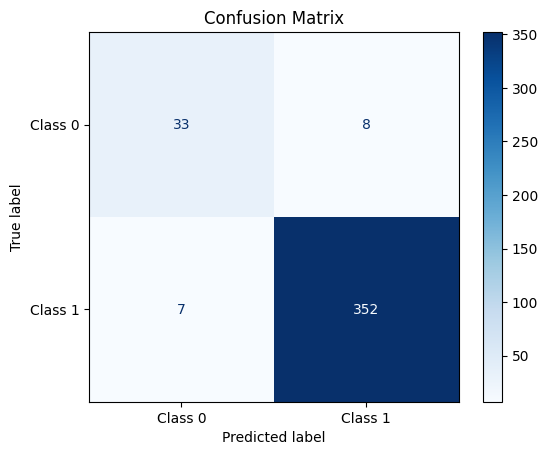

In [ ]:

# Step 7: Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    display_labels = ['Class 0', 'Class 1']

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Main workflow
def main():
    base_models = create_and_tune_models()
    datasets = generate_datasets()
    bagging_models = apply_bagging(base_models, datasets)
    top_models = evaluate_models(bagging_models)

    if len(top_models) < 7:
        print("Not enough models available for layered classification.")
        return

    final_predictions, y_test_combined = layered_classification(top_models, datasets)
    plot_confusion_matrix(y_test_combined, final_predictions)

# Run the workflow
if __name__ == "__main__":
    main()